 En este estudio, se llevó a cabo un análisis de sentimientos para cada revisión, cuantificando la polaridad de las opiniones expresadas. A partir de este cálculo, se asignó una puntuación de análisis de sentimientos, considerando tanto la valoración del sentimiento como la recomendación final. Previo al análisis, se aplicó un proceso de stemming a la columna 'review'. Esta técnica redujo las palabras a su raíz, facilitando la captura de la semántica subyacente y disminuyendo la dimensionalidad del espacio vectorial.
 

In [57]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer # importamos stemmer y lematizador
import string
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json
import ast
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import fastparquet
import pyarrow as pa
import pyarrow.parquet as pq



In [58]:
nltk.download('vader_lexicon')  # modelo vader_lexicon de NLTK
nltk.download('punkt')  # tokenizer de NLTK
nltk.download('wordnet')  # WordNet para lematización
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\naysc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\naysc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\naysc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\naysc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naysc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\naysc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-

True

Para efectuar un análisis de sentimiento detallado, se cargó el conjunto de datos en un DataFrame de Pandas. Esta estructura de datos permite una manipulación y exploración eficientes.

In [59]:
df = pd.read_parquet("australian_user_reviews_limpio.parquet")

In [60]:
df.sample(10)

,user_id,funny,posted,last_edited,item_id,helpful,recommend,review
54793,Sttea,,"Posted December 1, 2013.",,550,2 of 4 people (50%) found this review helpful,True,♥♥♥♥ mais meio chato e injoadivo
55842,Inkybots,,"Posted November 15, 2014.",,291480,0 of 2 people (0%) found this review helpful,False,The only thing that ruined this game was that ...
19401,Senioritis67789,,Posted July 13.,Last edited July 13.,570,2 of 4 people (50%) found this review helpful,False,Don't play this game*Too many games where peop...
30057,76561198124399539,,"Posted June 3, 2015.","Last edited June 3, 2015.",255710,2 of 2 people (100%) found this review helpful,True,as you can see i have played for over 500 hour...
1600,bruhbruhxd,,Posted April 12.,,242760,No ratings yet,True,10/10 Definitely the best Survival Game I have...
25368,stopreadingthisthing,,"Posted October 11, 2014.",,113200,No ratings yet,True,its like the first zelda on the NES mixed with...
52399,MegamanFury,5 people found this review funny,"Posted December 26, 2015.",,407510,2 of 5 people (40%) found this review helpful,True,5/7
5814,frost27820,,"Posted July 17, 2015.",,346110,0 of 2 people (0%) found this review helpful,True,10/10 ign best survival game out there
23395,76561198104824869,,"Posted February 22, 2014.",,6550,1 of 1 people (100%) found this review helpful,True,虽然不支持控制器和不能全银幕的游戏，但并不会减少游戏的可玩性和热趣，你依然可以灵活的进行华丽...
48676,76561198050462560,,"Posted February 14, 2014.",,236390,0 of 2 people (0%) found this review helpful,True,Fahken planes m8!


Se genera una réplica del archivo original para llevar a cabo las operaciones necesarias, garantizando así la integridad de los datos fuente.

In [61]:
df_copy = df.copy()
df_copy

,user_id,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...
...,...,...,...,...,...,...,...,...
59328,76561198312638244,,Posted July 10.,,70,No ratings yet,True,a must have classic from steam definitely wort...
59329,76561198312638244,,Posted July 8.,,362890,No ratings yet,True,this game is a perfect remake of the original ...
59330,LydiaMorley,1 person found this review funny,Posted July 3.,,273110,1 of 2 people (50%) found this review helpful,True,had so much fun plaing this and collecting res...
59331,LydiaMorley,,Posted July 20.,,730,No ratings yet,True,:D


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      59333 non-null  object
 1   funny        59305 non-null  object
 2   posted       59305 non-null  object
 3   last_edited  59305 non-null  object
 4   item_id      59305 non-null  object
 5   helpful      59305 non-null  object
 6   recommend    59305 non-null  object
 7   review       59305 non-null  object
dtypes: object(8)
memory usage: 3.6+ MB


Se verificó que las columnas 'review' y 'recommend' tuvieran el tipo de dato 'string' para garantizar la correcta aplicación de las operaciones de procesamiento de texto.

In [63]:
df_copy['review'] = df_copy['review'].astype(str)
df_copy['recommend'] = df_copy['recommend'].astype(bool)

Se procederá a la imputación de valores nulos, reemplazando las cadenas vacías y otros marcadores de datos faltantes como 'None', 'N/A' y 'NA', con el fin de garantizar la integridad y consistencia del conjunto de datos.

In [64]:
df_copy = df_copy.replace(['', 'None', 'N/A', 'NA'], np.nan)

In [65]:
df.isnull().sum()

user_id         0
funny          28
posted         28
last_edited    28
item_id        28
helpful        28
recommend      28
review         28
dtype: int64

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      59333 non-null  object
 1   funny        59305 non-null  object
 2   posted       59305 non-null  object
 3   last_edited  59305 non-null  object
 4   item_id      59305 non-null  object
 5   helpful      59305 non-null  object
 6   recommend    59305 non-null  object
 7   review       59305 non-null  object
dtypes: object(8)
memory usage: 3.6+ MB


 Para llevar a cabo un análisis preciso de la intensidad de sentimiento, es necesario inicializar una serie de herramientas. En primer lugar, se procede a la inicialización del stemmer, un algoritmo que reduce las palabras a su raíz o lexema. A continuación, se inicializa el lematizador, una herramienta más sofisticada que asigna a cada palabra su forma canónica o lema, considerando su contexto gramatical. Finalmente, se crean instancias de cada una de estas herramientas para su posterior aplicación en el proceso de análisis.

In [67]:
sid= SentimentIntensityAnalyzer()

stemmer = PorterStemmer()

lemmatizer = WordNetLemmatizer()  

In [68]:
print(df.columns.tolist())

['user_id', 'funny', 'posted', 'last_edited', 'item_id', 'helpful', 'recommend', 'review']


En la presente investigación, se emplea el algoritmo de stemming de NLTK para llevar a cabo la reducción morfológica de las palabras contenidas en la columna 'review' del DataFrame. Esta técnica permite obtener la raíz léxica de cada término, facilitando así la posterior etapa de análisis.
La función propuesta divide el texto en tokens individuales mediante word_tokenize y, a continuación, aplica el proceso de lematización a cada token utilizando lemmatizer.. De este modo, se obtiene la forma lemática de cada palabra, lo que contribuye a una representación lingüística más precisa y consistente.
Luego a fin de realizar el análisis de sentimiento, se ha diseñado una función que toma como entrada una reseña y devuelve una puntuación correspondiente a la polaridad del sentimiento expresado (negativo, neutral o positivo). En caso de que la reseña esté vacía, se asigna un valor neutral por defecto.

In [69]:
words_ingles = set(stopwords.words('english'))
words_español = set(stopwords.words('spanish'))
words_portugues = set(stopwords.words('portuguese'))

# Unimos los tres idiomas en un solo conjunto
words_lenguajes = words_ingles.union(words_español).union(words_portugues)

# Inicializar el analizador de sentimientos VADER
analyzer = SentimentIntensityAnalyzer()

# Función de procesamiento de texto y transformaciones
def transformaciones(text, remove_stopwords=True):  # Simplifiqué la función para enfoque en el análisis de sentimientos
    if pd.isna(text):  # Verificar si el texto es nulo
        return text
    
    # Convertir el texto a minúsculas
    text = text.lower()
    
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizar el texto
    words = word_tokenize(text)
    
    # Eliminar stopwords
    if remove_stopwords:
        words = [word for word in words if word not in words_lenguajes]
        
    # Unir las palabras procesadas nuevamente en una cadena
    return ' '.join(words)

# Función para asignar sentimiento basado en VADER
def asignar_sentimiento(text):
    if pd.isna(text) or text.strip() == '':
        return 1  # Neutral si la reseña está vacía o ausente
    
    # Preprocesar el texto
    text = transformaciones(text)
    # Obtener los puntajes de sentimiento de VADER
    scores = analyzer.polarity_scores(text)
    # Asignar el sentimiento basado en el puntaje de compound
    if scores['compound'] >= 0.05:
        return 2  # Positivo
    elif scores['compound'] <= -0.05:
        return 0  # Negativo
    else:
        return 1  # Neutral
    
# Aplicar el análisis de sentimientos a la columna 'review'
df_copy['sentiment_analysis'] = df_copy['review'].apply(asignar_sentimiento)

# Reemplazar la columna 'review' con 'sentiment_analysis'
df_copy['review'] = df_copy['sentiment_analysis']
# Mostrar el DataFrame con la columna de análisis de sentimientos
print(df_copy.head())

             user_id funny                     posted last_edited item_id  \
0  76561197970982479   NaN   Posted November 5, 2011.         NaN    1250   
1  76561197970982479   NaN      Posted July 15, 2011.         NaN   22200   
2  76561197970982479   NaN     Posted April 21, 2011.         NaN   43110   
3            js41637   NaN      Posted June 24, 2014.         NaN  251610   
4            js41637   NaN  Posted September 8, 2013.         NaN  227300   

                                           helpful  recommend  review  \
0                                   No ratings yet       True       2   
1                                   No ratings yet       True       2   
2                                   No ratings yet       True       2   
3  15 of 20 people (75%) found this review helpful       True       2   
4     0 of 1 people (0%) found this review helpful       True       2   

   sentiment_analysis  
0                   2  
1                   2  
2                   2  
3 

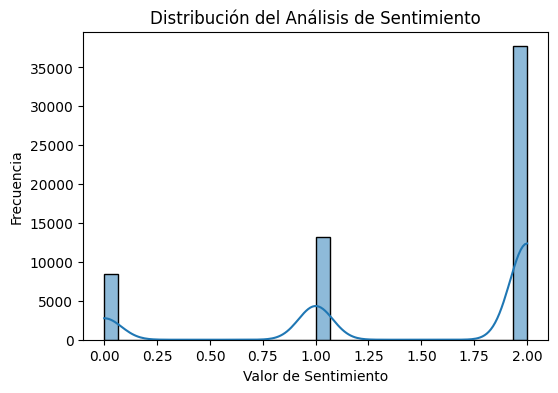

In [71]:
# Graficamos la distribución del análisis de sentimiento
plt.figure(figsize=(6, 4))
sns.histplot(df_copy['sentiment_analysis'], bins=30, kde=True)
plt.title('Distribución del Análisis de Sentimiento')
plt.xlabel('Valor de Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

Se llevó a cabo una revisión exhaustiva de los resultados del análisis, cuantificando así la tasa de errores.

In [72]:
# Reseñas con sentimiento positivo y recomendación negativa.
positive_negative = df_copy[(df_copy['sentiment_analysis'] == 2) & (df_copy['recommend'] == False)]
count_positive_negative = len(positive_negative)

# Reseñas con sentimiento negativo y recomendación positiva.
negative_positive = df_copy[(df_copy['sentiment_analysis'] == 0) & (df_copy['recommend'] == True)]
count_negative_positive = len(negative_positive)

print("Reviews con sentimiento positivo y recomendación negativa:", count_positive_negative)
print("Reviews con sentimiento positivo y recomendación negativa:", count_negative_positive)

mistakes = count_negative_positive + count_positive_negative
records= 58401
mistakes_rate= mistakes/records

print(f'la tasa de errores del análisis de sentimiento es', mistakes_rate)

Reviews con sentimiento positivo y recomendación negativa: 2787
Reviews con sentimiento positivo y recomendación negativa: 6006
la tasa de errores del análisis de sentimiento es 0.15056249036831562


In [74]:
total_mistakes = 2904 + 1323
total_records = 59333
percent_mistakes = (total_mistakes / total_records) * 100

print("Porcentaje de errores:", percent_mistakes)

Porcentaje de errores: 7.124197326951275


Una vez concluido el procesamiento de los datos, se procedió a exportar el archivo resultante al formato Parquet.

In [75]:
df_copy.to_parquet("user_reviews_analisis_ de_sentimientos.parquet", index=False)